# Check the SSI model in directly-supervised setting...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

In [2]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
print len(train)
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
print len(dev)

28087
27896


In [3]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

L_gold_train = label_manager.load(session, train, "CDR Training Label Set")
print L_gold_train.shape
L_gold_dev = label_manager.load(session, dev, "CDR Development Label Set")
print L_gold_dev.shape

(28087, 1)
(27896, 1)


# Load canonical & secondary dictionaries

In [4]:
from cPickle import load
cd = load(open('cd.pkl', 'rb'))

In [5]:
%%time
from entity_norm import CanonDictVectorizer 

# Create a vectorizer based around this 
cd_vectorizer = CanonDictVectorizer(cd.term_to_sids, other_phrases=[])

# Vectorize the dictionary
D_pos = cd_vectorizer.vectorize_phrases(cd.pos_terms)
D_pos

|V| = 271512
CPU times: user 39.6 s, sys: 1.65 s, total: 41.3 s
Wall time: 40.5 s


# Directly-Supervised SSI

Let's assume we have **only positives** and **ground truth CIDs**, and see if the model works!!!

In [6]:
N_train           = L_gold_train.shape[0]
train_pos_phrases = []
train_pos_labels  = []
for i in range(N_train):
    if L_gold_train[i,0] > 0:
        train_pos_phrases.append(train[i].disease.get_span().lower())
        train_pos_labels.append(L_gold_train[i,0])
        
X_train = cd_vectorizer.vectorize_phrases(train_pos_phrases)
X_train

<3870x271513 sparse matrix of type '<type 'numpy.float64'>'
	with 8502 stored elements in Compressed Sparse Row format>

In [7]:
from scipy.sparse import lil_matrix

N_train_pos = X_train.shape[0]
K           = len(set(cd.sid_to_cid.values()))
Y           = lil_matrix((N_train_pos, K))

for i in range(N_train_pos):
    Y[i, int(train_pos_labels[i])] = 1.0
Y = Y.tocsr()
Y

<3870x4790 sparse matrix of type '<type 'numpy.float64'>'
	with 3870 stored elements in Compressed Sparse Row format>

In [8]:
cid_sets = [set([cd.sid_to_cid[sid] for sid in cd.term_to_sids[t] if sid in cd.sid_to_cid]) for t in cd.pos_terms]

In [27]:
from entity_norm import SSIModel

model = SSIModel(D_pos, cid_sets)

In [33]:
%time model.train(X_train, Y, rate=1e-2, n_iter=30, n_iter_sample=1)

Iteration: 0
	3750Iteration: 1
	3750Iteration: 2
	3750Iteration: 3
	3750Iteration: 4
	3750Iteration: 5
	3750Iteration: 6
	3750Iteration: 7
	3750Iteration: 8
	3750Iteration: 9
	3750Iteration: 10
	3750Iteration: 11
	3750Iteration: 12
	3750Iteration: 13
	3750Iteration: 14
	3750Iteration: 15
	3750Iteration: 16
	3750Iteration: 17
	3750Iteration: 18
	3750Iteration: 19
	3750Iteration: 20
	3750Iteration: 21
	3750Iteration: 22
	3750Iteration: 23
	3750Iteration: 24
	3750Iteration: 25
	3750Iteration: 26
	3750Iteration: 27
	3750Iteration: 28
	3750Iteration: 29
	3750

CPU times: user 44min 26s, sys: 588 ms, total: 44min 27s
Wall time: 44min 23s


### Eval

In [11]:
N_dev           = L_gold_dev.shape[0]
dev_pos_phrases = []
dev_pos_labels  = []
for i in range(N_dev):
    if L_gold_dev[i,0] > 0:
        dev_pos_phrases.append(dev[i].disease.get_span().lower())
        dev_pos_labels.append(L_gold_dev[i,0])
        
X_dev = cd_vectorizer.vectorize_phrases(dev_pos_phrases)
X_dev

<3976x271513 sparse matrix of type '<type 'numpy.float64'>'
	with 8910 stored elements in Compressed Sparse Row format>

In [23]:
def get_set_scores(model, X, X_labels, N_pos, W=None, b=None, display=True):
    predicted = 0
    correct   = 0
    for i in range(X.shape[0]):
        yp = model.predict(X.getrow(i), W=W, b=b)
        if yp is not None:
            predicted += 1
        
            # NOTE: we assume we're doing disambiguation perfectly here!!!
            if X_labels[i] in yp:
                correct += 1

    prec   = correct / float(predicted)
    recall = correct / float(N_pos)
    f1     = (2 * prec * recall) / (prec +  recall)
    if display:
        print "P:\t", prec
        print "R:\t", recall
        print "F1:\t", f1
    return prec, recall, f1

In [13]:
from scipy import sparse
I = sparse.identity(X_train.shape[1], format='csr')

In [34]:
import matplotlib.pyplot as plt

train_f1s = []
dev_f1s   = []
for W, b in zip(model.Ws, model.bs):
    prec, recall, f1 = get_set_scores(model, X_train, train_pos_labels, N_train_pos, W=W, b=b, display=False)
    train_f1s.append(f1)
    prec, recall, f1 = get_set_scores(model, X_dev, dev_pos_labels, X_dev.shape[0], W=W, b=b, display=False)
    dev_f1s.append(f1)

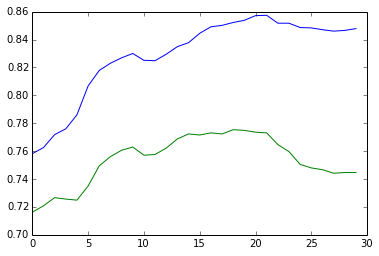

In [35]:
iters = range(len(model.Ws))
plt.plot(iters, train_f1s)
plt.plot(iters, dev_f1s)